In [1]:
include("GP.jl")

using Distributions
using LinearAlgebra
using Statistics

using PyPlot
using LaTeXStrings
using PyCall

plt[:style][:use]("ggplot")

In [15]:
f(x) = sin.(x) .- x./6 .+ 1

x⁺ = range(0, stop=4π, length=1000)
n  = 20
i = sort(1 .+ round.(Int, length(x⁺) * rand(20)))

σ² = 0.1^2

x = x⁺[i]
y = f(x) + sqrt.(σ²) * randn(n);

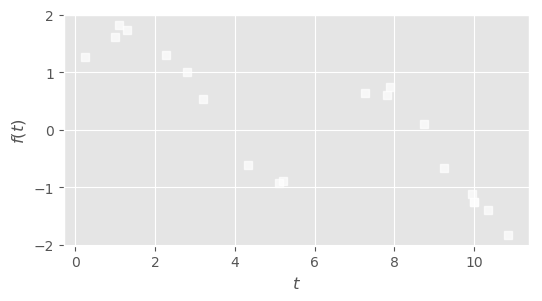

In [32]:
function plot_data()
    plot(x, y, "ws", alpha=0.7)
    xlabel(L"$t$"); ylabel(L"$f(t)$")
end

figure(figsize=(6,3))
plot_data();

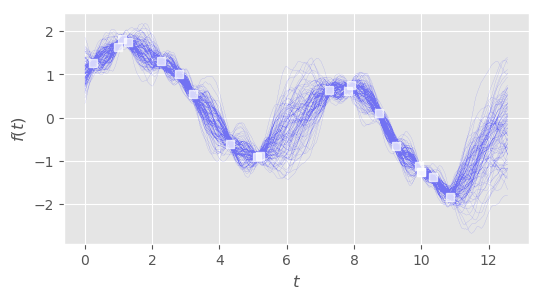

PyObject Text(28.000000000000007, 0.5, '$f(t)$')

In [52]:
params = Dict("lengthscale" => 1., "variance" => 0.5, "nu" => 1.5)
gp_predict = trained_gp(x, y, 𝑘=kern_matern, σ²=σ², θ=params)

μ₁,Σ₁ = gp_predict(x⁺);

function plot_samples(x, μ, Σ; n = 100, c="b")
    samples = sample_posterior(μ, Σ, n = n)
    
    connect_x, connect_y = [], []
    
    for i ∈ 1:n
        append!(connect_x, x)
        append!(connect_y, samples[i])
        push!(connect_x, NaN)
        push!(connect_y, NaN)
    end
    plot(connect_x, connect_y, c*"-", alpha=0.5, lw=0.1)
end


figure(figsize=(6,3))
plot_samples(x⁺, μ₁, Σ₁)
plot_data()

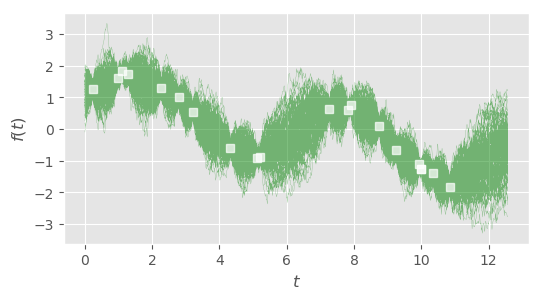

PyObject Text(28.000000000000007, 0.5, '$f(t)$')

In [47]:
params = Dict("lengthscale" => 2., "variance" => 1., "nu" => 0.5)
gp_predict = trained_gp(x, y, 𝑘=kern_matern, σ²=σ², θ=params)

μ₀, Σ₀ = gp_predict(x⁺);

figure(figsize=(6,3))
plot_samples(x⁺, μ₀, Σ₀, c="g")
plot_data()

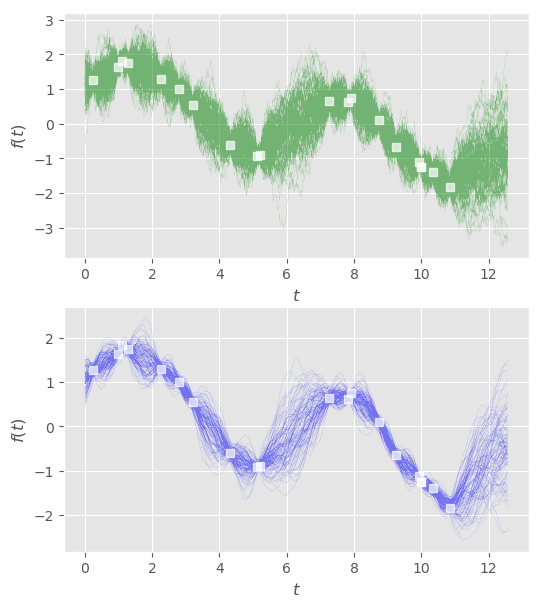

In [53]:
figure(figsize=(6,7))

subplot(211)
plot_samples(x⁺, μ₀, Σ₀, c="g")
plot_data()

subplot(212)
plot_samples(x⁺, μ₁, Σ₁, c="b")
plot_data()

savefig("/home/wil/Documents/presentations/vbcgp/figures/example_gps.pdf", bbox_inches="tight")

In [54]:
function increment_rk4!(f, func::Function, Δ::AbstractFloat)
    k₁ = Δ*func(f)
    k₂ = Δ*func(f + 0.5k₁)
    k₃ = Δ*func(f + 0.5k₂)
    k₄ = Δ*func(f + k₃)
    
    f .+= k₁/6. + k₂/3. + k₃/3. + k₄/6.
end

function increment_rk4(f, func::Function, Δ::AbstractFloat)
    """ """
    tmp = copy(f);
    increment_rkf!(tmp, func, Δ);
    return tmp
end

function lotka_volterra(f, θ, u::Union{Missing, Number}=missing)
    """ """
    ismissing(u) ? u = 0.0 : nothing;
    return [
        #θ[:α]*(1.0 + u)*f[1] - θ[:β]f[1]f[2],
        θ[:α]f[1] - θ[:β]f[1]f[2] + ((u == 0.0) ? θ[:σ]*u : u)
        θ[:β]θ[:δ]f[1]f[2] - θ[:γ]f[2]
    ]
end

function lotka_volterra!(df, f, θ, u::Union{Missing, Number}=missing)
    """ """
    df = lotka_volterra(f, θ, u)
end

function solve_lv(f₀, t; display::Bool=false)
    """ Solve Lotka Volterra for zero net migration """
    fs = zeros(size(f₀,1), length(t));
    fs[:,1] = f₀
    fₜ = copy(f₀);

    for i ∈ 2:length(t)
        increment_rk4!(fₜ,f -> lotka_volterra(f, θ, 0.0), t[i]-t[i-1])
        fs[:,i] = fₜ
    end
    
    display ? [plot(t, fs[i,:]) for i ∈ 1:size(f₀,1)] : nothing;
    
    return fs
end

solve_lv (generic function with 1 method)

In [61]:
include("SequentialGP.jl");

function solve_lfm_lv(f₀, t; display::Bool=false)
    """ Solve Lotka Volterra for with GP net migration """

    # kernel prior
    
    F, L, q, H = kern_seq_periodic(8, ω=4/2, v=20.);
    #F, L, q, H = kern_seq_matern(ν=7/2, l = 0.5);
    
    P₀ = cov_seq_steadystate(F, L, q);
    
    𝐷, 𝑁 = size(F, 1), length(f₀);
    
    A = exp(F * (t[2]-t[1]));
    Q = Hermitian(P₀ - A*P₀*A') |> Matrix; assertposdef!(Q);
    
    μ = rand(MvNormal(P₀));
    
    fs = zeros(size(H,1) + 𝑁, length(t));
    
    fˡ = [μ ; f₀]
    
    fs[:,1] = [H*μ ; f₀];
    
    fₜ = copy(fˡ)
    
    𝐇 = [H zeros(size(H,1), 𝑁) ; zeros(𝑁, size(H,2)) Matrix(I, 𝑁, 𝑁)]
    print(size(𝐇))
    for i ∈ 2:length(t)
        fₜ[1:𝐷] = A*fₜ[1:𝐷] + rand(MvNormal(Q));
        uᵛ = fₜ[𝐷+1:end]
        increment_rk4!(
            uᵛ,
            f -> lotka_volterra(f, θ, (H*fₜ[1:𝐷])[1]),
            t[i]-t[i-1]
        )
        fₜ[𝐷+1:end] = uᵛ;
        any(isnan.(fₜ)) ? (return fs[:,1:i-1]) : fs[:,i] = 𝐇 * fₜ
    end
    
    display ? [plot(t, fs[i,:]) for i ∈ (size(H,1)+1):size(fs,1)] : nothing;
    
    return fs
end

solve_lfm_lv (generic function with 1 method)

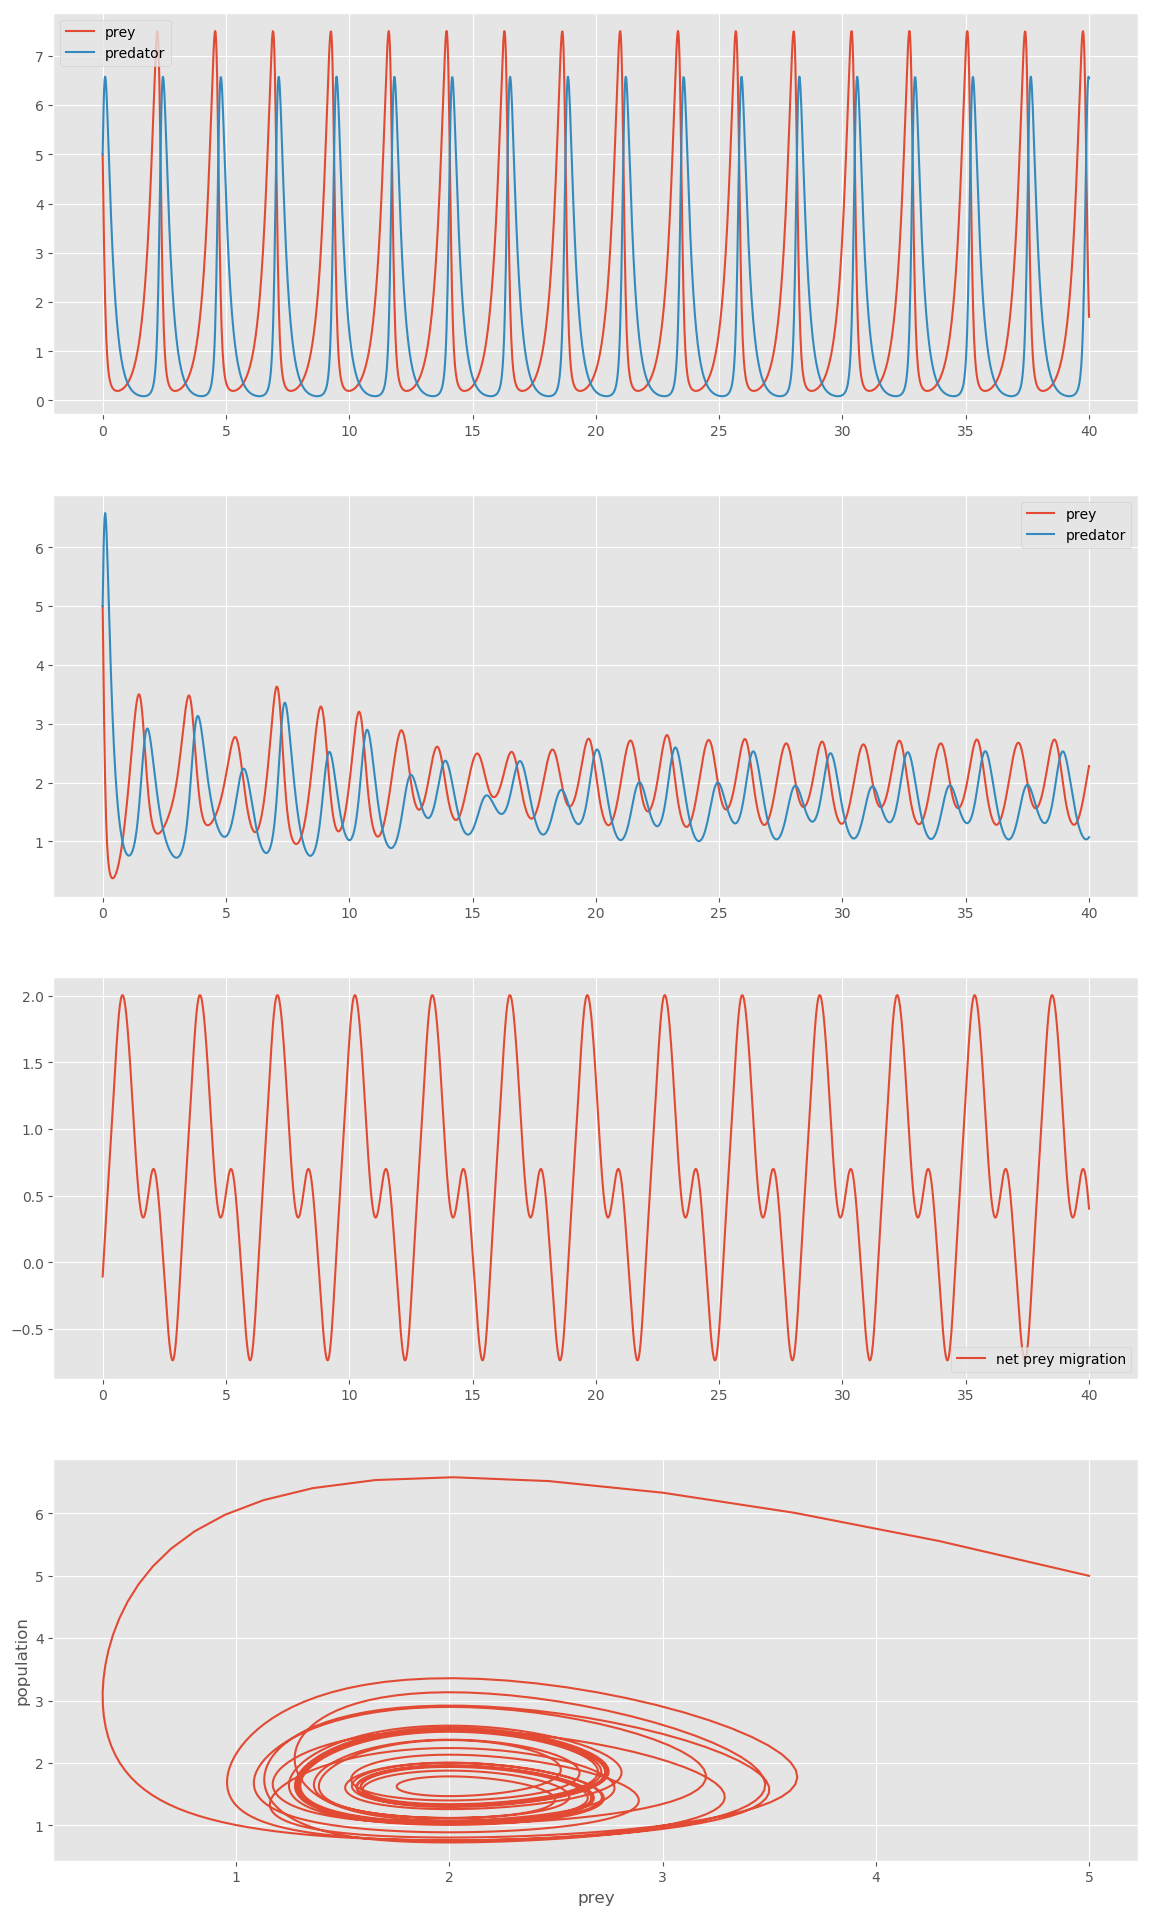

(3, 20)

In [67]:
t = range(0., stop=40., length=2000);

f₀ = [5.;5.]
    
θ = Dict(
    :α => 3.,
    :β => 2.,
    :δ => 1.,
    :γ => 4.,
    :σ => 1.
)

figure(figsize=(14,24))

subplot(411)
solve_lv(f₀, t, display=true);
legend(labels=["prey", "predator"])

subplot(412)
fs = solve_lfm_lv(f₀, t);
[plot(t, fs[i,:]) for i ∈ 2:3]
legend(labels=["prey", "predator"])

subplot(413)
plot(t,fs[1,:])
legend(labels=["net prey migration"])

subplot(414)
plot(fs[2,:], fs[3,:])
xlabel("prey"), ylabel("population")
; # supress output

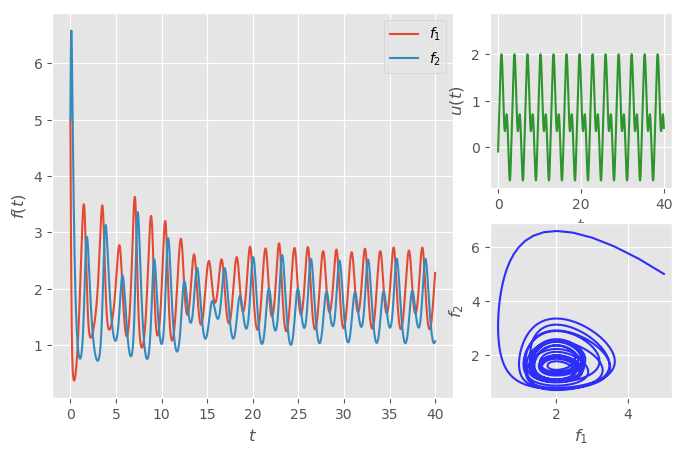

In [93]:
figure(figsize=(8,5))

ax1 = subplot2grid((2,3),(0,0), rowspan=2, colspan=2)
[plot(t, fs[i,:]) for i ∈ 2:3]
xlabel(L"$t$"), ylabel(L"$f(t)$")
legend(labels=[L"$f_1$", L"$f_2$"])

ax2 = subplot2grid((2,3),(0,2))
plot(t,fs[1,:],"g-", alpha=0.8)
ylim([-0.9, 2.9])
xlabel(L"$t$"), ylabel(L"$u(t)$")

ax3 = subplot2grid((2,3),(1,2))
plot(fs[2,:], fs[3,:],"b-", alpha=0.8)
xlabel(L"$f_1$"), ylabel(L"$f_2$")

savefig("/home/wil/Documents/presentations/vbcgp/figures/lv_plus_gp.pdf", bbox_inches="tight")